# Лабораторная работа 7. Понижение размерности. Отбор признаков. Извлечение признаков

В задачах машинного обучения практически всегда приходится иметь дело с данными, которые представлены **в пространствах высокой размерности**. Примеры:
- датафреймы с большим количеством столбцов (особенно после выполнения one-hot кодирования)
- пиксели изображения (особенно, если мы обрабатываем изображения классическими моделями)
- векторные представления слов / предложений / текстов (современные word2vec модели работают с пространствами размерности 300+)

**Понижение размерности - это** уменьшение количества признаков (переменных, столбцов) в наборе данных

## Для чего имеет смысл понижать размерность данных

Может показаться, что чем больше информации нам известно о данных, тем лучше и тем более качественные модели мы сможем построить, однако на практике это утверждение не работает. Можно привести следующие примеры, которые могут заставить задуматься о необходимости понижения размерности данных:
- работа с данными высокой размерности требует большого объема памяти и создает сильную нагрузку на процессор (каждый сталкивался с тем, что не получалось обучить модель на всем датасете после one-hot кодирования😀)
- высокая размерность данных может быть причиной переобучения моделей;
- решение задач кластеризации, а также других задач машинного обучения с помощью методов, основанных на анализе близости объектов (KMeans, DBSCAN, KNN, SVM и др.) может быть затруднено в виду так называемого **проклятия размерности** (Р. Беллман) - в пространствах высокой размерности все объекты кажутся одинаково близкими


А еще понижение размерности (в частности до 2 и 3 признаков) позволяет нам визуализировать сложные данные (в ML есть отдельная задача - визуализация данных)

**Существуют два подхода к понижению размерности данных:**
- отбор признаков (feature selection)
- выделение признаков (feature extraction)

Важно понимать, что в основе всех алгоритмов понижения размерности лежит понимание каждого признака как некоторой случайной величины. Если признаки зависят друг от друга, значит мы имеем дело с зависимыми случайными величинами. Данные в целом при таком подходе представляют собой совместное распределение нескольких случайных величин. **Цель понижения размерности: максимизация дисперсии (разброса) данных при переходе от высокой размерности к целевой.**

## Загрузка данных

Будем работать с уже знакомыми нам данными (банк)

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('bank_churners_preprocessed.csv')
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head()

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,c_F,c_M,c_Divorced,c_Married,c_Single,c_Unknown
0,0,45,3,2,3,0,39,5,1,3,...,1144,42,1.625,0.061,0,1,0,1,0,0
1,0,49,5,5,1,0,44,6,1,2,...,1291,33,3.714,0.105,1,0,0,0,1,0
2,0,51,3,5,4,0,36,4,1,0,...,1887,20,2.333,0.000,0,1,0,1,0,0
3,0,40,4,2,1,0,34,3,4,1,...,1171,20,2.333,0.760,1,0,0,0,0,1
4,0,40,3,1,3,0,21,5,1,0,...,816,28,2.500,0.000,0,1,0,1,0,0


In [ ]:
data = data.sort_values(by='Attrition_Flag', ascending=False)
data = data[:(data[data['Attrition_Flag'] == 1].shape[0]*2)]
data.shape

(3254, 24)

In [ ]:
data[data['Attrition_Flag'] == 0].shape, data[data['Attrition_Flag'] == 1].shape

((1627, 24), (1627, 24))

In [ ]:
data = data.sample(frac=1)

Набор данных содержит 24 признака. Будем пытаться понизить размерность

In [ ]:
X = data.drop(['Attrition_Flag'], axis=1)
y = data['Attrition_Flag']

Тестировать модель будем с помощью ансамбля

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
def test(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
  bag = BaggingClassifier().fit(X_train, y_train)
  print(classification_report(y_test, bag.predict(X_test)))

In [ ]:
import numpy as np

In [ ]:
np.random.seed(42)

In [ ]:
test(X, y)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       245
           1       0.99      1.00      0.99       244

    accuracy                           0.99       489
   macro avg       0.99      0.99      0.99       489
weighted avg       0.99      0.99      0.99       489



## 1. Отбор признаков

Отбор признаков предполагает, что мы удаляем из набора данных признаки, которые практически не несут в себе достаточно информации об объектах. **Мы оставляем в датасете только те признаки, которые раскрывают суть данных**. Мы рассмотрим несколько методов понижения размерности путем отбора признаков

### 1.1 Отбираем признаки с высокой дисперсией

Самый очевидный способ отбора признаков - брать признаки с высокой дисперсией. Такой подход предполагает, что мы работаем только с предикторами (игнорируем целевой признак)

In [ ]:
X.describe()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,c_F,c_M,c_Divorced,c_Married,c_Single,c_Unknown
count,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,...,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000
mean,46.766749,2.413337,2.889367,1.890596,0.076521,36.280578,3.750461,2.555931,2.559312,7212.709004,...,4012.848187,61.529809,0.657285,0.253836,0.625077,0.374923,0.077443,0.430854,0.414567,0.077136
std,7.371566,1.285434,1.990770,1.417368,0.330788,7.530996,1.550401,1.012574,1.080534,8405.128963,...,2257.919060,21.237771,0.216947,0.293958,0.484177,0.484177,0.267334,0.495272,0.492723,0.266848
min,26.000000,0.000000,0.000000,0.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,...,510.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,1.250000,1.000000,1.000000,0.000000,32.000000,3.000000,2.000000,2.000000,2140.250000,...,2326.000000,43.000000,0.516000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.000000,2.000000,3.000000,1.000000,0.000000,36.000000,4.000000,3.000000,3.000000,3412.000000,...,4096.000000,65.000000,0.674000,0.110500,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,3.000000,5.000000,3.000000,0.000000,40.000000,5.000000,3.000000,3.000000,8593.500000,...,4766.500000,79.000000,0.795750,0.502750,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,68.000000,5.000000,6.000000,5.000000,3.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,...,15999.000000,127.000000,2.500000,0.999000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Напоминаю, что дисперсия равна квадрату std

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
# параметр - порог значения дисперсии
# будут отобраны только те признаки, у которых дисперсия выше
vt = VarianceThreshold(2)
X_vt = vt.fit_transform(X)
X_vt.shape

(3254, 10)

In [ ]:
X_vt = pd.DataFrame(X_vt, columns=vt.get_feature_names_out())
X_vt.head()

,Customer_Age,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Amt,Total_Trans_Ct
0,42.0,3.0,2.0,30.0,5.0,1438.3,1223.0,215.3,2181.0,43.0
1,46.0,2.0,2.0,37.0,6.0,2375.0,1196.0,1179.0,4087.0,66.0
2,50.0,6.0,0.0,36.0,5.0,4045.0,0.0,4045.0,2438.0,41.0
3,41.0,0.0,2.0,25.0,4.0,4277.0,2186.0,2091.0,8764.0,69.0
4,37.0,0.0,1.0,27.0,6.0,3061.0,2517.0,544.0,5032.0,89.0


Все модели для понижения размерности, как правило, реализуют общий интерфейс: fit + transform. На этапе fit модель "обучается" (считаются статистические функции, различные матрицы преобразования и т.д.). На этапе transform выполняется преобразование данных. При выполнении метода fit_transform модель сразу же "обучается" и выполняет преобразование данных

In [ ]:
test(X_vt, y)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       245
           1       0.98      0.99      0.98       244

    accuracy                           0.98       489
   macro avg       0.98      0.98      0.98       489
weighted avg       0.98      0.98      0.98       489



Обратите внимание, что у нас данные не нормированы, в следствие чего дисперсия отдельных признаков может различаться на порядки. При использовании рассматриваемой стратегии отбора признаков обычно производится масштабирование данных

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,c_F,c_M,c_Divorced,c_Married,c_Single,c_Unknown
0,-0.646739,-1.877739,0.055582,0.077200,-0.231365,-0.834092,0.806070,-0.549112,0.407906,-0.687116,...,-0.811424,-0.872627,-0.296361,2.028368,0.774470,-0.774470,-0.289731,-0.870069,1.188342,-0.289107
1,-0.104030,2.012597,-0.446814,0.077200,-0.231365,0.095543,1.451163,-0.549112,-1.443315,-0.575655,...,0.032846,0.210515,0.810068,0.851149,-1.291206,1.291206,-0.289731,1.149335,-0.841508,-0.289107
2,0.438679,-0.321604,1.562768,-1.334084,-0.231365,-0.037262,0.806070,-0.549112,1.333516,-0.376936,...,-0.697585,-0.966814,-0.891067,-0.863644,0.774470,-0.774470,-0.289731,1.149335,-0.841508,-0.289107
3,-0.782417,-0.321604,-1.451605,0.077200,-0.231365,-1.498117,0.160976,-0.549112,0.407906,-0.349330,...,2.104540,0.351795,0.118550,0.874965,-1.291206,1.291206,3.451478,-0.870069,-0.841508,-0.289107
4,-1.325125,-0.321604,-1.451605,-0.628442,-0.231365,-1.232507,1.451163,-1.536846,0.407906,-0.494025,...,0.451437,1.293658,-0.181108,1.933101,0.774470,-0.774470,-0.289731,-0.870069,1.188342,-0.289107


In [ ]:
vt = VarianceThreshold(1)
X_vt = vt.fit_transform(X_scaled)
print(X_vt.shape)
test(X_vt, y)

(3254, 8)
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       245
           1       0.97      0.98      0.97       244

    accuracy                           0.97       489
   macro avg       0.97      0.97      0.97       489
weighted avg       0.97      0.97      0.97       489



В данном случае видим, что качество полученных моделей не сильно уменьшилось - но посмотрите насколько уменьшилась размерность. Более чем в два раза в обоих случаях! При этом, возможно, было переобучение, и мы боремся с ним понимая размерность.

### 1.2 Одномерный отбор признаков

Одномерный отбор признаков предполагает, что для каждого признака оценивается степень его влияния на целевую переменную. Признаки с небольшим влиянием удаляются. В качестве оценки обычно используются статистические тесты (чаще всего [тест Фишера](https://ru.wikipedia.org/wiki/F-%D1%82%D0%B5%D1%81%D1%82))

In [ ]:
from sklearn.feature_selection import SelectKBest

In [ ]:
skb = SelectKBest(k=6)
X_skb = skb.fit_transform(X, y)
test(X_skb, y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       245
           1       0.99      0.99      0.99       244

    accuracy                           0.99       489
   macro avg       0.99      0.99      0.99       489
weighted avg       0.99      0.99      0.99       489



In [ ]:
X_skb = pd.DataFrame(X_skb, columns=skb.get_feature_names_out())
X_skb

,Total_Relationship_Count,Contacts_Count_12_mon,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,5.0,3.0,2181.0,43.0,0.593,0.850
1,6.0,1.0,4087.0,66.0,0.833,0.504
2,5.0,4.0,2438.0,41.0,0.464,0.000
3,4.0,3.0,8764.0,69.0,0.683,0.511
4,6.0,3.0,5032.0,89.0,0.618,0.822
...,...,...,...,...,...,...
3249,5.0,2.0,3691.0,77.0,0.510,0.000
3250,6.0,2.0,8642.0,77.0,0.481,0.000
3251,1.0,3.0,8688.0,69.0,0.769,0.087
3252,3.0,2.0,4220.0,79.0,0.612,0.811


### 1.3 Рекурсивный отбор признаков

Рекурсивный отбор признаков предполагает обучение множества моделей. Сначала модель обучается на всех признаках, а затем мы начинаем исключать из модели признаки с низкой значимостью. Делаем это до тех пор, пока не останется столько признаков, сколько нам нужно получить

Важный момент состоит в том, каким образом мы исключаем признаки. Происходит это на основе значения значимости признака. Обученные регрессионные модели и деревья решений хранят информацию о значимости признаков (коэффициенты в линейных моделях и значения значимости признаков у деревьев). Можно отсортировать признаки по этим значениям и производить отбор

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier().fit(X, y)

In [ ]:
rfe = RFE(estimator=tree, n_features_to_select=4, step=1).fit(X, y)
X_rfe = pd.DataFrame(rfe.transform(X), columns=rfe.get_feature_names_out())
X_rfe

,Total_Relationship_Count,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1
0,5.0,2181.0,43.0,0.593
1,6.0,4087.0,66.0,0.833
2,5.0,2438.0,41.0,0.464
3,4.0,8764.0,69.0,0.683
4,6.0,5032.0,89.0,0.618
...,...,...,...,...
3249,5.0,3691.0,77.0,0.510
3250,6.0,8642.0,77.0,0.481
3251,1.0,8688.0,69.0,0.769
3252,3.0,4220.0,79.0,0.612


In [ ]:
test(X_rfe, y)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       245
           1       0.98      0.98      0.98       244

    accuracy                           0.98       489
   macro avg       0.98      0.98      0.98       489
weighted avg       0.98      0.98      0.98       489



Бум! Осталось 4 признака, а модель все еще могЁт!

### 1.4 Отбор признаков по их значимости

Во многих случаях можно не использовать рекурсивный отбор, а просто взять обученное дерево и сразу же взять нужное количество признаков с самой высокой значимостью

In [11]:
import matplotlib.pyplot as plt

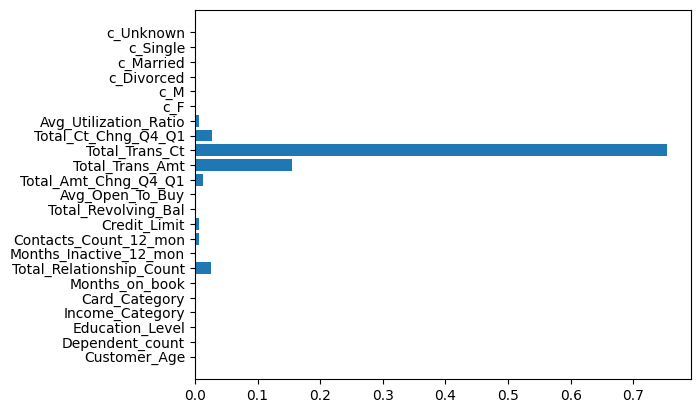

In [ ]:
plt.barh(width=tree.feature_importances_, y=X.columns);

Напомню еще раз, что при решении задачи регрессии с использованием линейных моделей мы можем в качестве оценки значимости признака использовать коэффициенты. Вы будете использовать этот факт при выполнении задания.

## 2. Выделение признаков

В отличие от отбора признаков, когда мы исключаем из датасета ненужные признаки, при выделении **мы производим преобразование данных из пространства высокой размерности в пространство низкой размерности**. Важно понимать, что при таком подходе по сути мы вводим "новые оси". Это означает, что признаки в целевом пространстве мы уже не сможем интерпретировать

### 2.1 Метод главных компонент

Метод главных компонент (Principal Component Analysis - PCA) - это один из наиболее часто используемых методов извлечения признаков, который вам потребуется реализовать самостоятельно.

Чтобы выполнить понижение размерности методом PCA необходимо последовательно выполнить следующие действия.

1. Стандартизация данных (итерируемся по столбцам, от каждого элемента столбца отнимаем среднее по столбцу и делим на отклонение столбца - то, что делает StandartScaller).
2. Вычисление ковариационной матрицы.
3. Вычисление собственных векторов и собственных значений ковариационной матрицы.
4. Сортировка пар <собственное значение, собственный вектор> по убыванию.
5. Выбор первых k пар <собственное значение, собственный вектор>, где k - размерность целевого пространства.
6. Матрица, составленная из k собственных векторов - матрица преобразования из данного пространства в пространство с размерностью k.
7. Чтобы произвести понижение размерности необходимо умножить матрицу стандартизированных входных данных (результат пункта 1) на матрицу из k собственных векторов (результат пункта 6).

На основе пункта 7 можно сделать, что PCA - линейный метод понижения размерности

Собственные значения и вектора можно посчитать с помощью numpy в одну строку

При работе с numpy **следите за размерностью**. Имейте в виду, что в некоторых местах придется выполнять транспонирование матриц, даже если оно не предусмотрено в формулах (в виду особенностей представления матриц в numpy)

Более подробно:
- https://habr.com/ru/articles/304214/
- https://www.turing.com/kb/guide-to-principal-component-analysis (вот здесь прям формулы, которые рекомендуется использовать)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)
X_pca.shape

(3254, 2)

Данные имеют размерность 2 - их можно визуализировать

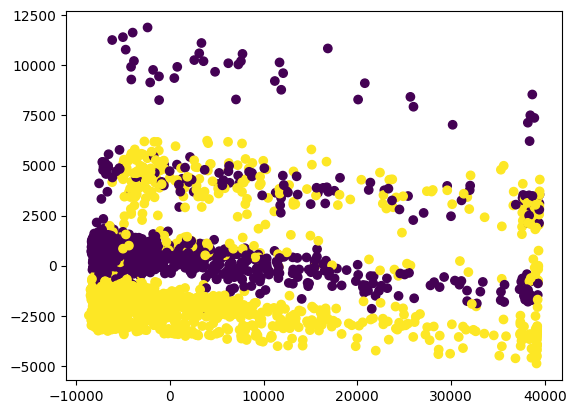

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y);

Мы понизили размерность до 2 признаков, и теперь имеет смысл оценить, сколько информации мы потеряли

In [ ]:
sum(pca.explained_variance_ratio_)

0.9924448371305413

Видно, что мы сохранили более 99% информации понизив размерность до 2 - попробуем выполнить классификацию

In [ ]:
test(X_pca, y)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       245
           1       0.96      0.89      0.92       244

    accuracy                           0.92       489
   macro avg       0.93      0.92      0.92       489
weighted avg       0.93      0.92      0.92       489



Качестве классификации понизилось, но при этом мы получили данные с размерностью 2!

In [ ]:
pca_2 = PCA(n_components=3)
X_pca_2 = pca_2.fit_transform(X, y)

In [ ]:
test(X_pca_2, y)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       245
           1       0.97      0.90      0.93       244

    accuracy                           0.94       489
   macro avg       0.94      0.94      0.94       489
weighted avg       0.94      0.94      0.94       489



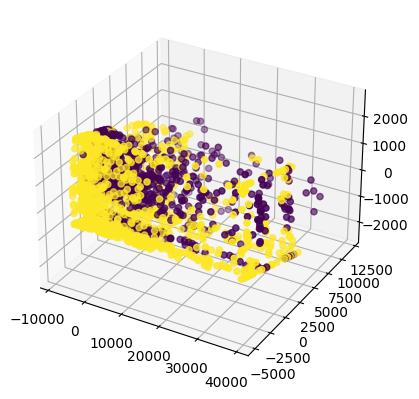

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_pca_2[:,0], X_pca_2[:,1], X_pca_2[:,2], c=y);

### 2.2 Нелинейные методы выделения признаков

Нелинейные методы понижения размерности предполагают, что данные должны быть расположены на нелинейной поверхности меньшей размерности, чем исходное пространство

Полезные материалы:
- https://habr.com/ru/articles/267041/
- https://medium.com/nuances-of-programming/%D0%B4%D0%BE%D1%85%D0%BE%D0%B4%D1%87%D0%B8%D0%B2%D0%BE-%D0%BE%D0%B1-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B8-%D0%BD%D0%B0-%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5-%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%B8%D0%B9-%D1%81-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B0%D0%BC%D0%B8-isomap-t-sne-%D0%B8-lle-8fbb30851953
- https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0

Распространены такие алгоритмы, как t-SNE (t-distributed Stochastic Neighbor Embedding) и Isomap. Существует при этом множество других алгоритмов

In [ ]:
from sklearn.manifold import TSNE, Isomap

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

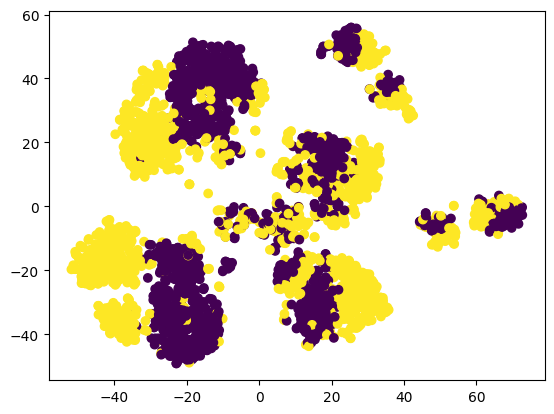

In [ ]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y);

In [ ]:
test(X_tsne, y)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       245
           1       0.93      0.88      0.90       244

    accuracy                           0.91       489
   macro avg       0.91      0.91      0.91       489
weighted avg       0.91      0.91      0.91       489



In [ ]:
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_scaled)

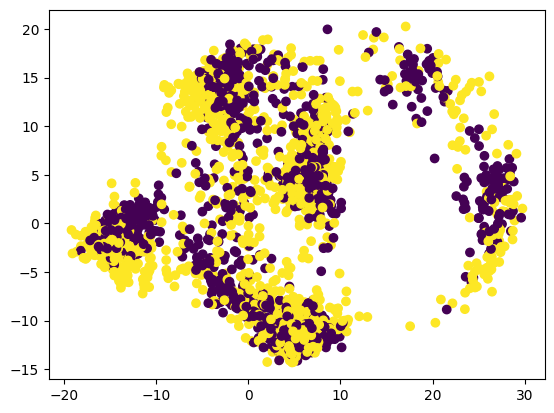

In [ ]:
plt.scatter(X_isomap[:,0], X_isomap[:,1], c=y);

Попробуем применить к результату tSNE алгоритм KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


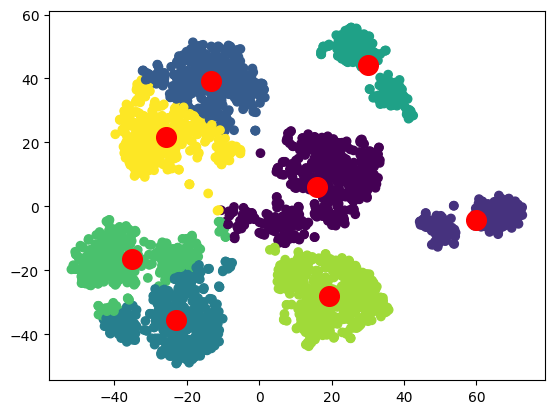

In [ ]:
kmeans = KMeans(n_clusters=8).fit(X_tsne)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=200);

In [ ]:
silhouette_score(X_tsne, kmeans.labels_)

0.5069558

Результат классификации - **клиентов банка можно разделить на 8 групп**, которые достаточно сильно отличаются друг от друга. Этот факт может быть использован, например если банк захочет каждой группе предлагать определенные услуги. Интерпретация групп является задачей исследователя

**Понижение размерности в машинном обучении играет очень важную роль**, поскольку оптимизирует вычислительные затраты, дает возможность визуализировать данные и позволяет избежать "проклятия размерности"

## Задания

1. Используйте **наборы данных для классификации и регрессии**, с помощью которых вы выполняли ЛР1-ЛР4.
2. С помощью классов библиотеки sklearn выполните понижение размерности (**размерность выберите сами, можно разные**) с использованием всех описанных методов (VarianceThreshold, SelectKBest, RFE, PCA, tSNE, Isomap).
3. **Выберите две модели** (одна - для регрессии и другая - для классификации).
4. Обучите выбранные модели с использованием данных в пространстве низкой размерности - **используйте результаты выполнения пункта 3** (не забудьте, что понижать нужно и X_train и X_test - проще всего понижать X). **Сделайте вывод** о том, какие методы понижения размерности лучше всего подходят для ваших данных.
5. **Самостоятельно реализуйте алгоритм PCA**. Выполните с его помощью понижение размерности датасета для классификации до 2 (преобразуйте данные в двумерное пространство). **Выполните визуализацию данных** (точки на плоскости).
6. Попробуйте выполнить **кластеризацию преобразованных в пункте 5 данных с помощью вашей реализации алгоритма KMeans** из ЛР6.
7. Используйте оригинальный датасет для регрессии (без понижения размерности). Обучите любую из линейных моделей, реализованных вами в ЛР1. **Важно: модель должна быть реализована вами, не sklearn!** Посмотрите значения коэффициентов модели, выберите несколько признаков с наибольшими значениями коэффициентов.


## Загрузка данных

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [3]:
def test_classification(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    bagging = DecisionTreeClassifier().fit(X_train, y_train)
    print(classification_report(y_test, bagging.predict(X_test)))

In [4]:
def test_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    tree = DecisionTreeRegressor().fit(X_train, y_train)
    print("mse =", mean_squared_error(y_test, tree.predict(X_test)))
    print("mae =", mean_absolute_error(y_test, tree.predict(X_test)))
    print("r2 =", r2_score(y_test, tree.predict(X_test)))

### Классификация

In [5]:
data_class = pd.read_csv('../data/pred_card_transdata.csv')
data_class.drop(['Unnamed: 0'], axis=1, inplace=True)
data_class.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,-0.377995,0.155206,-0.507410,1,0,0,1,0
1,-0.346242,-0.201807,-0.730339,1,1,0,1,0
2,-0.344031,0.025102,-0.156792,1,0,0,1,0
3,-0.392158,-0.222599,0.138186,1,0,0,1,1
4,-0.384379,-0.197035,1.184226,1,1,0,1,1


In [20]:
data_class.shape[1]

8

In [21]:
np.random.seed(42)

In [6]:
X_class = data_class.drop(['fraud'], axis=1)
y_class = data_class['fraud']

In [190]:
test_classification(X_class, y_class)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17527
           1       1.00      1.00      1.00     17435

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962



### Регрессия

In [7]:
data_regress = pd.read_csv('../data/pred_kc_house_data.csv')
data_regress.drop(['Unnamed: 0'], axis=1, inplace=True)
data_regress.head()

,day,month,year,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront,price
0,-0.311319,1.099621,-0.690655,-0.398737,-1.447464,-0.979835,-0.228321,-0.915427,-0.305759,-0.629187,...,-0.658681,-0.544898,-0.210128,1.870152,-0.352572,-0.306079,-0.943355,-0.260715,0,221900.0
1,-0.774557,1.741627,-0.690655,-0.398737,0.175607,0.533634,-0.189885,0.936506,-0.305759,-0.629187,...,0.245141,-0.681079,4.746678,0.879568,1.161568,-0.746341,-0.432686,-0.187868,0,538000.0
2,1.078396,-1.468403,1.447901,-1.473959,-1.447464,-1.426254,-0.123298,-0.915427,-0.305759,-0.629187,...,-0.658681,-1.293892,-0.210128,-0.933388,1.283537,-0.135655,1.070140,-0.172375,0,180000.0
3,-0.774557,1.741627,-0.690655,0.676485,1.149449,-0.130550,-0.244014,-0.915427,-0.305759,2.444294,...,1.397515,-0.204446,-0.210128,1.085160,-0.283288,-1.271816,-0.914174,-0.284522,0,604000.0
4,0.267729,-1.468403,1.447901,-0.398737,-0.149007,-0.435422,-0.169653,-0.915427,-0.305759,-0.629187,...,-0.658681,0.544548,-0.210128,-0.073636,0.409550,1.199335,-0.272190,-0.192849,0,510000.0


In [31]:
data_regress.shape[1]

22

In [34]:
np.random.seed(42)

In [8]:
X_regress = data_regress.drop(['price'], axis=1)
y_regress = data_regress['price']

In [72]:
test_regression(X_regress, y_regress)

mse = 35855914140.13648
mae = 103540.78417765441
r2 = 0.7389243421783434


## Отбор признаков с высокой дисперсией (VarianceThreshold)

In [73]:
from sklearn.feature_selection import VarianceThreshold

### Классификация

In [119]:
X_class.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
count,1.748060e+05,1.748060e+05,1.748060e+05,174806.000000,174806.000000,174806.000000,174806.000000
mean,8.113242e-17,-6.828780e-18,4.873636e-17,0.881137,0.308376,0.056777,0.784853
std,1.000003e+00,1.000003e+00,1.000003e+00,0.323628,0.461824,0.231417,0.410926
min,-4.204679e-01,-2.229982e-01,-7.785355e-01,0.000000,0.000000,0.000000,0.000000
25%,-3.813421e-01,-2.148712e-01,-6.356355e-01,1.000000,0.000000,0.000000,1.000000
50%,-3.096403e-01,-1.950881e-01,-3.577093e-01,1.000000,0.000000,0.000000,1.000000
75%,-6.382164e-02,-1.226276e-01,3.193987e-01,1.000000,1.000000,0.000000,1.000000
max,9.995641e+01,1.294210e+02,5.521097e+01,1.000000,1.000000,1.000000,1.000000


In [193]:
vt = VarianceThreshold(0.8)
X_class_vt = vt.fit_transform(X_class)
print(X_class_vt.shape)
test_classification(X_class_vt, y_class)

(174806, 3)
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     17527
           1       0.93      0.92      0.93     17435

    accuracy                           0.93     34962
   macro avg       0.93      0.93      0.93     34962
weighted avg       0.93      0.93      0.93     34962



### Регрессия

In [118]:
X_regress.describe()

,day,month,year,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront
count,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,...,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,21613.000000
mean,-1.906791e-17,4.931357e-17,1.423459e-13,2.367051e-16,-1.788439e-16,2.393352e-16,3.945085e-17,-1.157225e-16,7.890171e-17,-2.893063e-16,...,1.157225e-16,7.364159e-17,1.914681e-15,3.945085e-18,-8.962774e-14,-3.432175e-14,-3.668403e-14,8.416182e-17,5.260114e-18,0.007542
std,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,...,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,0.086517
min,-1.701034e+00,-1.789406e+00,-6.906548e-01,-3.624404e+00,-2.745920e+00,-1.948891e+00,-3.521759e-01,-9.154270e-01,-3.057595e-01,-3.702668e+00,...,-1.809494e+00,-6.586810e-01,-2.417383e+00,-2.101284e-01,-1.438025e+00,-2.916795e+00,-2.166543e+00,-2.316325e+00,-4.438052e-01,0.000000
25%,-8.903670e-01,-8.263974e-01,-6.906548e-01,-3.987371e-01,-4.736214e-01,-7.108948e-01,-2.430487e-01,-9.154270e-01,-3.057595e-01,-6.291869e-01,...,-7.226314e-01,-6.586810e-01,-6.810785e-01,-2.101284e-01,-8.399369e-01,-6.426977e-01,-8.102505e-01,-7.244971e-01,-2.808593e-01,0.000000
50%,3.610979e-02,-1.843914e-01,-6.906548e-01,-3.987371e-01,1.756067e-01,-1.849914e-01,-1.808075e-01,1.053939e-02,-3.057595e-01,-6.291869e-01,...,-2.758102e-01,-6.586810e-01,1.360059e-01,-2.101284e-01,-2.418484e-01,8.478232e-02,-1.143518e-01,-2.138280e-01,-1.885636e-01,0.000000
75%,8.467770e-01,7.786176e-01,1.447901e+00,6.764851e-01,5.002207e-01,5.118578e-01,-1.066880e-01,9.365058e-01,-3.057595e-01,9.075535e-01,...,5.091458e-01,6.066704e-01,8.849999e-01,-2.101284e-01,7.487357e-01,8.512345e-01,6.312541e-01,5.448802e-01,-9.835556e-02,0.000000
max,1.773254e+00,1.741627e+00,1.447901e+00,3.185793e+01,7.641730e+00,1.247807e+01,3.950434e+01,3.714405e+00,4.914129e+00,2.444294e+00,...,9.204044e+00,1.023238e+01,1.497813e+00,4.806428e+00,2.262647e+00,1.570054e+00,6.383070e+00,6.162239e+00,3.144029e+01,1.000000


In [111]:
vt = VarianceThreshold(0.9)
X_regress_vt = vt.fit_transform(X_regress)
print(X_regress_vt.shape)
test_regression(X_regress_vt, y_regress)

(21613, 20)
mse = 39687874711.00671
mae = 105096.15174647236
r2 = 0.711022902463919


## Одномерный отбор признаков (SelectKBest)

In [120]:
from sklearn.feature_selection import SelectKBest

### Классификация

In [194]:
skb = SelectKBest(k=4)
X_class_skb = skb.fit_transform(X_class, y_class)
test_classification(X_class_skb, y_class)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     17527
           1       0.93      0.93      0.93     17435

    accuracy                           0.93     34962
   macro avg       0.93      0.93      0.93     34962
weighted avg       0.93      0.93      0.93     34962



In [195]:
X_class_skb = pd.DataFrame(X_class_skb, columns=skb.get_feature_names_out())
X_class_skb

,distance_from_home,ratio_to_median_purchase_price,used_pin_number,online_order
0,-0.377995,-0.507410,0.0,1.0
1,-0.346242,-0.730339,0.0,1.0
2,-0.344031,-0.156792,0.0,1.0
3,-0.392158,0.138186,0.0,1.0
4,-0.384379,1.184226,0.0,1.0
...,...,...,...,...
174801,-0.384734,-0.501225,0.0,0.0
174802,0.805875,-0.677156,0.0,1.0
174803,-0.175663,1.263701,0.0,1.0
174804,-0.384208,-0.640147,1.0,1.0


### Регрессия

In [145]:
skb = SelectKBest(k=12)
X_regress_skb = skb.fit_transform(X_regress, y_regress)
test_regression(X_regress_skb, y_regress)

mse = 52252454674.430374
mae = 126078.4487624335
r2 = 0.6195371306500099


In [146]:
X_regress_skb = pd.DataFrame(X_regress_skb, columns=skb.get_feature_names_out())
X_regress_skb

,bedrooms,bathrooms,sqft_living,floors,view,grade,sqft_above,sqft_basement,yr_renovated,lat,sqft_living15,waterfront
0,-0.398737,-1.447464,-0.979835,-0.915427,-0.305759,-0.558836,-0.734708,-0.658681,-0.210128,-0.352572,-0.943355,0.0
1,-0.398737,0.175607,0.533634,0.936506,-0.305759,-0.558836,0.460841,0.245141,4.746678,1.161568,-0.432686,0.0
2,-1.473959,-1.447464,-1.426254,-0.915427,-0.305759,-1.409587,-1.229834,-0.658681,-0.210128,1.283537,1.070140,0.0
3,0.676485,1.149449,-0.130550,-0.915427,-0.305759,-0.558836,-0.891699,1.397515,-0.210128,-0.283288,-0.914174,0.0
4,-0.398737,-0.149007,-0.435422,-0.915427,-0.305759,0.291916,-0.130895,-0.658681,-0.210128,0.409550,-0.272190,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21608,-0.398737,0.500221,-0.598746,2.788439,-0.305759,0.291916,-0.312039,-0.658681,-0.210128,1.004958,-0.666135,0.0
21609,0.676485,0.500221,0.250539,0.936506,-0.305759,0.291916,0.629908,-0.658681,-0.210128,-0.356180,-0.228419,0.0
21610,-1.473959,-1.772078,-1.154047,0.936506,-0.305759,-0.558836,-0.927928,-0.658681,-0.210128,0.247888,-1.410253,0.0
21611,-0.398737,0.500221,-0.522528,0.936506,-0.305759,0.291916,-0.227505,-0.658681,-0.210128,-0.184414,-0.841221,0.0


## Рекурсивный отбор признаков (RFE)

### Классификация

In [150]:
from sklearn.feature_selection import RFE

In [184]:
tree_class = DecisionTreeClassifier().fit(X_class, y_class)

In [185]:
rfe = RFE(estimator=tree_class, n_features_to_select=4, step=1).fit(X_class, y_class)
X_class_rfe = pd.DataFrame(rfe.transform(X_class), columns=rfe.get_feature_names_out())
X_class_rfe

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,online_order
0,-0.377995,0.155206,-0.507410,1.0
1,-0.346242,-0.201807,-0.730339,1.0
2,-0.344031,0.025102,-0.156792,1.0
3,-0.392158,-0.222599,0.138186,1.0
4,-0.384379,-0.197035,1.184226,1.0
...,...,...,...,...
174801,-0.384734,0.076984,-0.501225,0.0
174802,0.805875,-0.198069,-0.677156,1.0
174803,-0.175663,-0.212807,1.263701,1.0
174804,-0.384208,-0.207714,-0.640147,1.0


In [163]:
test_classification(X_class_rfe, y_class)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     17527
           1       0.98      1.00      0.99     17435

    accuracy                           0.99     34962
   macro avg       0.99      0.99      0.99     34962
weighted avg       0.99      0.99      0.99     34962



### Регрессия

In [186]:
tree_regress = DecisionTreeRegressor().fit(X_regress, y_regress)

In [187]:
rfe = RFE(estimator=tree_regress, n_features_to_select=6, step=1).fit(X_regress, y_regress)
X_regress_rfe = pd.DataFrame(rfe.transform(X_regress), columns=rfe.get_feature_names_out())
X_regress_rfe

,sqft_living,grade,lat,long,sqft_living15,waterfront
0,-0.979835,-0.558836,-0.352572,-0.306079,-0.943355,0.0
1,0.533634,-0.558836,1.161568,-0.746341,-0.432686,0.0
2,-1.426254,-1.409587,1.283537,-0.135655,1.070140,0.0
3,-0.130550,-0.558836,-0.283288,-1.271816,-0.914174,0.0
4,-0.435422,0.291916,0.409550,1.199335,-0.272190,0.0
...,...,...,...,...,...,...
21608,-0.598746,0.291916,1.004958,-0.938069,-0.666135,0.0
21609,0.250539,0.291916,-0.356180,-1.051685,-0.228419,0.0
21610,-1.154047,-0.558836,0.247888,-0.604321,-1.410253,0.0
21611,-0.522528,0.291916,-0.184414,1.028910,-0.841221,0.0


In [182]:
test_regression(X_regress_rfe, y_regress)

mse = 35527101718.97074
mae = 108090.72773536896
r2 = 0.7413185056298808


## Метод главных компонент (PCA)

### Классификация

In [8]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=2)
X_class_pca = pca.fit_transform(X_class, y_class)
X_class_pca.shape

(174806, 2)

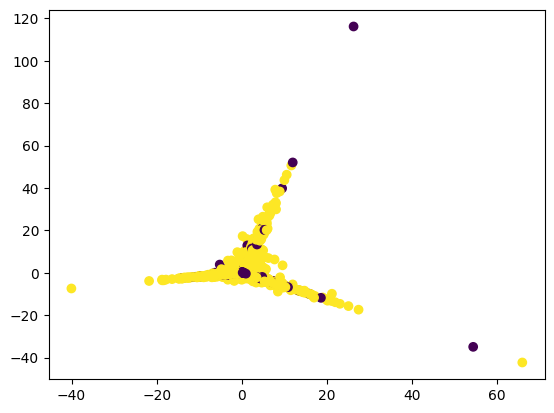

In [198]:
plt.scatter(X_class_pca[:,0], X_class_pca[:,1], c=y_class)

In [199]:
sum(pca.explained_variance_ratio_)

0.5919405618722231

In [201]:
test_classification(X_class_pca, y_class)

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     17527
           1       0.91      0.90      0.90     17435

    accuracy                           0.91     34962
   macro avg       0.91      0.91      0.91     34962
weighted avg       0.91      0.91      0.91     34962



In [203]:
pca_2 = PCA(n_components=3)
X_class_pca_2 = pca_2.fit_transform(X_class, y_class)

In [205]:
test_classification(X_class_pca_2, y_class)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     17527
           1       0.94      0.94      0.94     17435

    accuracy                           0.94     34962
   macro avg       0.94      0.94      0.94     34962
weighted avg       0.94      0.94      0.94     34962



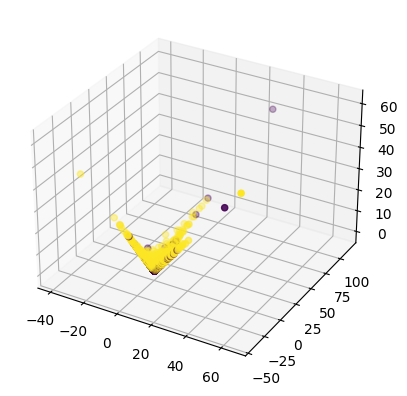

In [206]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_class_pca_2[:,0], X_class_pca_2[:,1], X_class_pca_2[:,2], c=y_class);

### Регрессия

In [57]:
pca = PCA(n_components=2)
X_regress_pca = pca.fit_transform(X_regress, y_regress)
X_regress_pca.shape

(21613, 2)

In [17]:
test_regression(X_regress_pca_2, y_regress)

mse = 99581302353.4793
mae = 194681.5820032385
r2 = 0.2749242449359308


In [9]:
pca_2 = PCA(n_components=3)
X_regress_pca_2 = pca_2.fit_transform(X_regress, y_regress)

In [13]:
test_regression(X_regress_pca_2, y_regress)

mse = 100772856137.46681
mae = 194475.2748091603
r2 = 0.26624825115792816


## t-SNE

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Классификация

In [12]:
tsne = TSNE(n_components=2)
X_class_tsne = tsne.fit_transform(X_class)

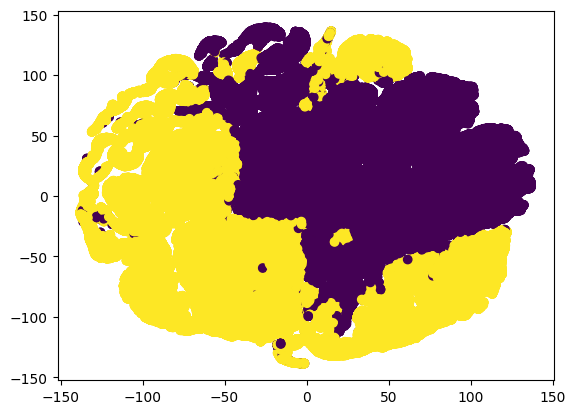

In [15]:
plt.scatter(X_class_tsne[:,0], X_class_tsne[:,1], c=y_class)

In [16]:
test_classification(X_class_tsne, y_class)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     17527
           1       0.99      1.00      1.00     17435

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962



### Регрессия

In [27]:
tsne = TSNE(n_components=2)
X_regress_tsne = tsne.fit_transform(X_regress)

In [28]:
test_regression(X_regress_tsne, y_regress)

mse = 66294306623.16077
mae = 143702.68332176728
r2 = 0.5172949811339986


## Isomap

In [18]:
from sklearn.manifold import Isomap

### Классификация

In [ ]:
isomap = Isomap(n_components=2)
X_class_isomap = isomap.fit_transform(X_class)

In [ ]:
plt.scatter(X_isomap[:,0], X_isomap[:,1], c=y)

### Регрессия

In [29]:
isomap = Isomap(n_components=2)
X_regress_isomap = isomap.fit_transform(X_regress)

MemoryError: Unable to allocate 3.48 GiB for an array with shape (21613, 21613) and data type float64

In [ ]:
plt.scatter(X_regress_isomap[:,0], X_regress_isomap[:,1], c=y_regress)

## Реализация RCA

In [33]:
import numpy as np

class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        cov = np.cov(X.T)

        eigenvectors, eigenvalues = np.linalg.eig(cov)
        eigenvectors = eigenvectors.T

        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = eigenvectors[:self.n_components]

    def transform(self, X):
        
        X = X - self.mean
        return np.dot(X, self.components.T)

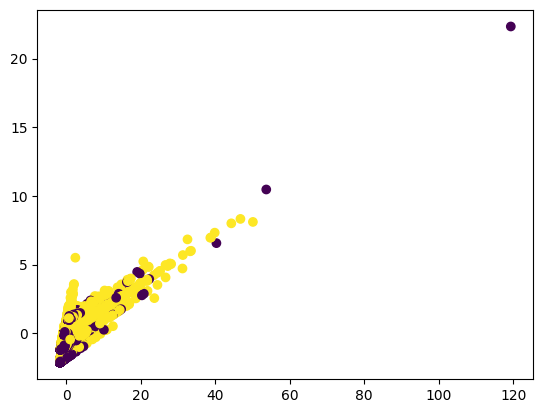

In [34]:
pca = PCA(2)
pca.fit(X_class)
X_new_class = pca.transform(X_class)
plt.scatter(X_new_class[:,0], X_new_class[:,1], c=y_class)

## Kmeans

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def euclidean_distance(sample_1, sample_2):
    return np.sqrt(np.sum((sample_1-sample_2)**2))

class KMeans:

    def __init__(self, K=3, max_iters=100):
        
        self.K = K
        self.max_iters = max_iters
        self.clusters = [[] for i in range(self.K)]   # список индексов объектов каждого кластера
        self.centroids = []   #центры кластеров

    def predict(self, X):
        
        self.X = X
        centroids_idxs = np.random.choice(self.X.shape[0], self.K, replace=False) #выбор K различных центров кластеров
        self.centroids = [self.X[i] for i in centroids_idxs]

        for iter in range(self.max_iters):
            
            self.clusters = self.create_clusters(self.centroids)  #назначение объекта к ближайшему центроиду
            centroids_old = self.centroids
            self.centroids = self.new_centroids(self.clusters)  #вычисление новых центроидов
            
            distances = [euclidean_distance(centroids_old[i], self.centroids[i]) for i in range(self.K)]
            if sum(distances) == 0:
                break

        return self.get_predictions(self.clusters)   # получение меток
 
    def get_predictions(self, clusters):
        
        # назначение кластеров объектам
        
        predictions = np.empty(self.X.shape[0])
        for cluster_idx, cluster in enumerate(clusters):
            for idx in cluster:
                predictions[idx] = cluster_idx

        return predictions

    def create_clusters(self, centroids):

        clusters = [[] for i in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self.closest_centroid(sample, centroids)  ## расчет расстояния от объекта до центроидов, выбор min
            clusters[centroid_idx].append(idx)
        return clusters

    def closest_centroid(self, sample, centroids):
        
        #определение расстояние от объекта до каждого центроида
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_idx = np.argmin(distances)
        return closest_idx

    def new_centroids(self, clusters):
        
        # расчет среднего значения
        centroids = np.zeros((self.K, self.X.shape[1]))
        for cluster_idx, cluster in enumerate(clusters):
            mean_value_cluster = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = mean_value_cluster
        return centroids

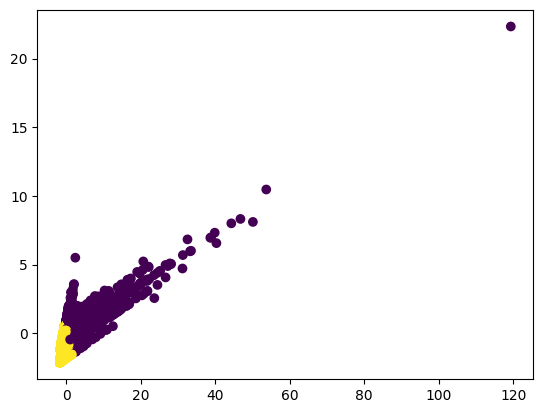

In [35]:
k = KMeans(K=2, max_iters=100)
y_pred = k.predict(X_new_class)
plt.scatter(X_new_class[:,0], X_new_class[:,1], c=y_pred)

## Ridge Regression

In [36]:
class Ridge_Regression:
    
    def __init__(self, rate = 0.01, iters = 5000, alpha = 0.9):
        
        self.rate = rate
        self.iters = iters
        self.alpha = alpha
    
    def add_ones(self, x):
        
        return np.concatenate((np.ones((len(x), 1)), x), axis=1)
    
    def ridge_error(self, x, y, w):
        
        return np.sum((y - np.dot(x, w)) ** 2) / x.shape[0] + np.sum(w ** 2) * self.alpha / x.shape[0]
    
    def gradient(self, x, y, w):
        
        return 2 / x.shape[0] * np.dot(y - np.dot(x, w), -x) + 2 / x.shape[0] * self.alpha * w
         
    def coef(self):
        
        return self.w[:-1]
    
    def intercept(self):
        
        return self.w[-1]
    
    def predict(self, x):
        
        return np.dot(self.add_ones(x), self.w) 
    
    def fit(self, x, y):
        
        delta_error = np.inf
        eps = 1e-4
        X = self.add_ones(x)
        w = np.zeros(X.shape[1])
        i = 0
        
        while delta_error > eps and i <= self.iters:
            
            error = self.ridge_error(X, y, w)
            w -= self.rate * self.gradient(X, y, w)
            delta_error = error - self.ridge_error(X, y, w)
            i += 1
            
            print(f'Итерация: {i}\n')
            print(f'Веса: {w}\n')
            print(f'Delta_error: {delta_error}\n')
            print("--------------------------------------------------------")
        
        self.w = w
        

In [37]:
ridge = Ridge_Regression()
ridge.fit(X_regress, y_regress)

Итерация: 1

Веса: [10801.76283533  -107.71270884   -74.01709336    26.25662983
  2264.01809195  3855.75599959  5154.60397674   658.3235773
  1885.47677965  2917.0774041    266.98185741  4900.55197058
  4446.30162523  2377.57835186   396.57286798   928.32420573
  -390.63525751  2254.13438896   158.7879513   4298.07087904
   605.35783428   250.66931199]

Delta_error: 24317818929.477844

--------------------------------------------------------
Итерация: 2

Веса: [21387.44360816  -208.92136988  -151.35866219    66.69167808
  4243.02090021  7304.98537343  9840.98765567  1225.57869765
  3539.13977241  5647.32541988   583.46816321  9375.30773455
  8463.93904821  4585.55899765   595.07522385  1815.975746
  -676.45141962  4438.89303257   188.70302094  8187.53500087
  1114.1164322    493.90441031]

Delta_error: 21655557198.471252

--------------------------------------------------------
Итерация: 3

Веса: [31761.36526103  -304.18651103  -231.35939044   119.64105183
  5966.13432669 10389.5411052

In [38]:
largest_coef_idx = np.argsort(ridge.coef())[-10:]

In [39]:
largest_coef_idx

array([ 3, 10, 13,  5,  9, 12,  6, 17, 11,  0], dtype=int64)

In [40]:
X_ = data_regress.iloc[:, largest_coef_idx]

In [41]:
test_regression(X_, y_regress)

mse = 76807041414.81679
mae = 165826.59657645153
r2 = 0.4407491945586136
